# IMPORT LIBRARIES

In [1]:
from minio import Minio
from minio.error import S3Error
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from delta import *
from functools import reduce
from pyspark.sql import functions as F
from delta.tables import DeltaTable
from pyspark.sql.window import Window

# CONNECT TO MINIO (LOAD BUCKET)

In [2]:
# Stop the existing SparkContext if it exists
try:
    sc.stop()
except NameError:
    pass


builder = SparkSession.builder.appName("Delta With MinIO") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.path.style.access", True) \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [3]:
# Set your MinIO configurations
minio_access_key = 'minioadmin'
minio_secret_key = 'minioadmin'
minio_endpoint = 'http://minio:9000'  # Example: 'play.min.io'
minio_bucket = 'ecommerce'

# Set the configurations for accessing MinIO
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", minio_access_key)
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", minio_secret_key)
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", minio_endpoint)
spark._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")


# LOAD DATA FROM MINIO

In [4]:
# Load file from MinIO bucket
minio_file_path_jan = '2020-Jan.csv'
minio_file_url_jan = f"s3a://{minio_bucket}/{minio_file_path_jan}"
df_jan = spark.read.csv(minio_file_url_jan, header=True)

# Show the loaded DataFrame
df_jan.show()

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2020-01-01 00:00:...|      view|   1005073|2232732093077520756|construction.tool...|samsung|1130.02|519698804|69b5d72f-fd6e-4fe...|
|2020-01-01 00:00:...|      view|   1005192|2232732093077520756|construction.tool...|  meizu| 205.67|527767423|7f596032-ccbf-464...|
|2020-01-01 00:00:...|      view| 100063693|2053013552427434207|       apparel.shirt| turtle| 136.43|519046195|d1e2f343-84bb-49b...|
|2020-01-01 00:00:...|      view|   5100816|2232732103831716449|       apparel.shoes| xiaomi|  29.95|518269232|0444841c-38ef-410...|
|2020-01-01 00:00:...|      view| 100014325|2232732103294845523|appar

In [5]:
# Load file from MinIO bucket
minio_file_path_feb = '2020-Feb.csv'
minio_file_url_feb = f"s3a://{minio_bucket}/{minio_file_path_feb}"
df_feb = spark.read.csv(minio_file_url_feb, header=True)

# Show the loaded DataFrame
df_feb.show()

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2020-02-01 00:00:...|      view| 100010426|2232732115290555244|       apparel.shoes|   null|  19.31|581521975|82d5664d-7980-43e...|
|2020-02-01 00:00:...|      view| 100071077|2232732079706079299|       sport.bicycle|  crown|  11.88|596313635|3df590c0-e667-4f5...|
|2020-02-01 00:00:...|      view|   1004665|2232732093077520756|construction.tool...|samsung| 838.23|608821035|3e271f43-db51-46b...|
|2020-02-01 00:00:...|      view|   1002544|2232732093077520756|construction.tool...|  apple| 410.42|530488542|21f46782-fb36-4d5...|
|2020-02-01 00:00:...|      view| 100010151|2053013563835941749|appli

In [6]:
# Load file from MinIO bucket
minio_file_path_mar = '2020-Mar.csv'
minio_file_url_mar = f"s3a://{minio_bucket}/{minio_file_path_mar}"
df_mar = spark.read.csv(minio_file_url_mar, header=True)

# Show the loaded DataFrame
df_mar.show()

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2020-03-01 00:00:...|      view|  10900348|2232732105912091273|appliances.kitche...| kitfort| 117.63|550295099|23f5ab9e-7774-416...|
|2020-03-01 00:00:...|      view|  14300020|2232732107967300275|   apparel.underwear|   casio| 264.37|622070532|edf19213-f0dd-46e...|
|2020-03-01 00:00:...|      view|  13200063|2232732061804790604|furniture.bedroom...|    null| 126.10|552832344|608087d8-6b69-21d...|
|2020-03-01 00:00:...|      view| 100077498|2232732085846540487|construction.tool...|  tamina| 424.72|613391860|5ab6c3d5-edd7-4e1...|
|2020-03-01 00:00:...|      view|   1005014|223273209307752075

In [7]:
# Load file from MinIO bucket
minio_file_path_apr = '2020-Apr.csv'
minio_file_url_apr = f"s3a://{minio_bucket}/{minio_file_path_apr}"
df_apr = spark.read.csv(minio_file_url_apr, header=True)

# Show the loaded DataFrame
df_apr.show()

+--------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|    brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+
|2020-04-01 00:00:...|      view|   1201465|2232732101407408685|apparel.shoes.sli...|  samsung| 230.38|568984877|e2456cef-2d4f-42b...|
|2020-04-01 00:00:...|      view|   1307156|2053013554658804075|electronics.audio...|    apple|1352.67|514955500|38f43134-de83-471...|
|2020-04-01 00:00:...|      view|   1480477|2053013563835941749|appliances.kitche...|    apple|1184.05|633645770|16aba270-b3c2-4b2...|
|2020-04-01 00:00:...|      view|   1307050|2053013554658804075|electronics.audio...|    apple|1724.34|564933778|05b443bd-e68a-4d7...|
|2020-04-01 00:00:...|      view|   9500109|22327321041

# CLEAN THE DATA

## REMOVE UNWANTED DATA

we decided to remove the view from the column event_type because the data is very large and we don't need them for answering our business questions

In [8]:
# Filtering rows where 'event_type' column is not equal to 'view' for each DataFrame
df_jan = df_jan.filter(col('event_type') != 'view')
df_feb = df_feb.filter(col('event_type') != 'view')
df_mar = df_mar.filter(col('event_type') != 'view')
df_apr = df_apr.filter(col('event_type') != 'view')


In [9]:
# Splitting 'category_code' column into 'main_category' and 'secondary_category'
df_jan = df_jan.withColumn('main_category', split(col('category_code'), '\.')[0]) \
               .withColumn('secondary_category', when(split(col('category_code'), '\.').getItem(1).isNull(), 'N/A')
                                                .otherwise(split(col('category_code'), '\.')[1]))

# Print the modified DataFrame
df_jan.show()  # Displaying the modified DataFrame


+--------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+-------------+------------------+
|          event_time|event_type|product_id|        category_id|       category_code|    brand|  price|  user_id|        user_session|main_category|secondary_category|
+--------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+-------------+------------------+
|2020-01-01 00:00:...|      cart|   1005124|2232732093077520756|construction.tool...|    apple|1453.18|532239316|253616df-2b1e-4bd...| construction|             tools|
|2020-01-01 00:00:...|      cart|   1201565|2232732101407408685|apparel.shoes.sli...|    apple| 385.34|581430108|7d7687c4-b613-446...|      apparel|             shoes|
|2020-01-01 00:00:...|      cart|  13101067|2232732106860003995|                null|     skad| 266.67|519373619|e97a30d7-2873-401...|         null|            

In [10]:
# Splitting 'category_code' column into 'main_category' and 'secondary_category'
df_feb = df_feb.withColumn('main_category', split(col('category_code'), '\.')[0]) \
               .withColumn('secondary_category', when(split(col('category_code'), '\.').getItem(1).isNull(), 'N/A')
                                                .otherwise(split(col('category_code'), '\.')[1]))

# Print the modified DataFrame
df_feb.show()  # Displaying the modified DataFrame


+--------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+-------------+------------------+
|          event_time|event_type|product_id|        category_id|       category_code|    brand|  price|  user_id|        user_session|main_category|secondary_category|
+--------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+-------------+------------------+
|2020-02-01 00:00:...|      cart|   1005100|2232732093077520756|construction.tool...|  samsung| 140.28|608822162|8062ce43-662e-4b6...| construction|             tools|
|2020-02-01 00:00:...|      cart| 100001549|2053013558978937451|       sport.bicycle|     puma|  38.15|608821784|600f4508-f562-4b2...|        sport|           bicycle|
|2020-02-01 00:00:...|      cart| 100065078|2232732093077520756|construction.tool...|   xiaomi| 568.61|526615078|5f0aab9f-f92e-4ef...| construction|            

In [11]:
# Splitting 'category_code' column into 'main_category' and 'secondary_category'
df_mar = df_mar.withColumn('main_category', split(col('category_code'), '\.')[0]) \
               .withColumn('secondary_category', when(split(col('category_code'), '\.').getItem(1).isNull(), 'N/A')
                                                .otherwise(split(col('category_code'), '\.')[1]))

# Print the modified DataFrame
df_mar.show()  # Displaying the modified DataFrame


+--------------------+----------+----------+-------------------+--------------------+---------+------+---------+--------------------+-------------+------------------+
|          event_time|event_type|product_id|        category_id|       category_code|    brand| price|  user_id|        user_session|main_category|secondary_category|
+--------------------+----------+----------+-------------------+--------------------+---------+------+---------+--------------------+-------------+------------------+
|2020-03-01 00:00:...|  purchase|   5100722|2232732103101907535|  electronics.clocks|   huawei|128.68|604860058|f558a7d7-f1e4-4b8...|  electronics|            clocks|
|2020-03-01 00:00:...|  purchase| 100082062|2232732102103663163|furniture.bedroom...|      arg| 48.88|601908129|37473d3f-b68b-4a2...|    furniture|           bedroom|
|2020-03-01 00:00:...|      cart|   6902464|2232732078733000751|electronics.telep...|   zlatek| 49.91|531574188|48714293-b3f9-494...|  electronics|         telephone

In [12]:
# Splitting 'category_code' column into 'main_category' and 'secondary_category'
df_apr = df_apr.withColumn('main_category', split(col('category_code'), '\.')[0]) \
               .withColumn('secondary_category', when(split(col('category_code'), '\.').getItem(1).isNull(), 'N/A')
                                                .otherwise(split(col('category_code'), '\.')[1]))

# Print the modified DataFrame
df_apr.show()  # Displaying the modified DataFrame


+--------------------+----------+----------+-------------------+--------------------+----------+-------+---------+--------------------+-------------+------------------+
|          event_time|event_type|product_id|        category_id|       category_code|     brand|  price|  user_id|        user_session|main_category|secondary_category|
+--------------------+----------+----------+-------------------+--------------------+----------+-------+---------+--------------------+-------------+------------------+
|2020-04-01 00:00:...|      cart|   5100328|2232732103101907535|  electronics.clocks|    xiaomi| 117.12|635164513|c40d1b96-90aa-4ce...|  electronics|            clocks|
|2020-04-01 00:00:...|      cart| 100177859|2053013551932506308|construction.tool...|  s.oliver|  60.49|633281427|667a8535-221c-416...| construction|             tools|
|2020-04-01 00:00:...|      cart|  22700202|2232732091643068746|                null|     stels| 171.18|515979190|5526811f-230a-476...|         null|      

In [13]:
# Dropping 'category_code' column from each DataFrame
df_jan = df_jan.drop('category_code')
df_feb = df_feb.drop('category_code')
df_mar = df_mar.drop('category_code')
df_apr = df_apr.drop('category_code')

# Print the modified DataFrames
df_jan.show()
df_feb.show()
df_mar.show()
df_apr.show()


+--------------------+----------+----------+-------------------+---------+-------+---------+--------------------+-------------+------------------+
|          event_time|event_type|product_id|        category_id|    brand|  price|  user_id|        user_session|main_category|secondary_category|
+--------------------+----------+----------+-------------------+---------+-------+---------+--------------------+-------------+------------------+
|2020-01-01 00:00:...|      cart|   1005124|2232732093077520756|    apple|1453.18|532239316|253616df-2b1e-4bd...| construction|             tools|
|2020-01-01 00:00:...|      cart|   1201565|2232732101407408685|    apple| 385.34|581430108|7d7687c4-b613-446...|      apparel|             shoes|
|2020-01-01 00:00:...|      cart|  13101067|2232732106860003995|     skad| 266.67|519373619|e97a30d7-2873-401...|         null|               N/A|
|2020-01-01 00:00:...|      cart|   4801028|2232732079706079299|   xiaomi|  14.95|574723072|2f967c6e-b6c4-497...|     

merging all dataframes from January until April

In [14]:
# Create a list of DataFrames to concatenate
dfs_to_concat = [df_jan, df_feb, df_mar, df_apr]

# Use reduce to perform vertical concatenation (union) of DataFrames
combined_df = reduce(lambda x, y: x.union(y), dfs_to_concat)

# Show the combined DataFrame
combined_df.show()


+--------------------+----------+----------+-------------------+---------+-------+---------+--------------------+-------------+------------------+
|          event_time|event_type|product_id|        category_id|    brand|  price|  user_id|        user_session|main_category|secondary_category|
+--------------------+----------+----------+-------------------+---------+-------+---------+--------------------+-------------+------------------+
|2020-01-01 00:00:...|      cart|   1005124|2232732093077520756|    apple|1453.18|532239316|253616df-2b1e-4bd...| construction|             tools|
|2020-01-01 00:00:...|      cart|   1201565|2232732101407408685|    apple| 385.34|581430108|7d7687c4-b613-446...|      apparel|             shoes|
|2020-01-01 00:00:...|      cart|  13101067|2232732106860003995|     skad| 266.67|519373619|e97a30d7-2873-401...|         null|               N/A|
|2020-01-01 00:00:...|      cart|   4801028|2232732079706079299|   xiaomi|  14.95|574723072|2f967c6e-b6c4-497...|     

We are droping the user_id, product_id, and category_id because we don't need this column in our project and it may take up some storage space. Further explanation is available in data obsevatory.


In this project, since we don't have the product name, only the product id, what we do is drop the NaN in category_code. But in real world, we wouldn't delete it, and instead we bind it with the product name in another database and make a machine learning classification to determine which categories the product goes.

The reason why we drop user_session NaN is because there aren't a lot of NaN there, and since we need the column, we cannot drop the whole column nor replace it with a random id because we are not sure if the missing values may be the same person.

In [15]:
columns_to_drop = ['user_id', 'product_id', 'category_id']
df_dropped = combined_df.drop(*columns_to_drop)

columns_to_check_null = ['user_session', 'main_category', 'secondary_category']
for column in columns_to_check_null:
    df_dropped = df_dropped.filter(F.col(column).isNotNull())

combined_df_clean = df_dropped

combined_df_clean.show()

+--------------------+----------+---------+-------+--------------------+-------------+------------------+
|          event_time|event_type|    brand|  price|        user_session|main_category|secondary_category|
+--------------------+----------+---------+-------+--------------------+-------------+------------------+
|2020-01-01 00:00:...|      cart|    apple|1453.18|253616df-2b1e-4bd...| construction|             tools|
|2020-01-01 00:00:...|      cart|    apple| 385.34|7d7687c4-b613-446...|      apparel|             shoes|
|2020-01-01 00:00:...|      cart|   xiaomi|  14.95|2f967c6e-b6c4-497...|        sport|           bicycle|
|2020-01-01 00:00:...|      cart|    apple| 890.11|7dad15db-dd6d-4e5...| construction|             tools|
|2020-01-01 00:00:...|      cart|    apple| 869.46|2a5143e3-2de9-4dc...| construction|             tools|
|2020-01-01 00:00:...|      cart|    apple| 967.85|84c838d4-6e10-4b7...| construction|             tools|
|2020-01-01 00:00:...|      cart|    apple| 86

In [16]:
print(combined_df_clean.count())

14473670


In [17]:
# Get unique values from the 'event_type' column
unique_categories = combined_df_clean.select(col('event_type')).distinct().rdd.map(lambda row: row[0]).collect()

# Print unique values
print(unique_categories)

['purchase', 'cart']


In [18]:
# Assuming 'event_time' is your datetime column
combined_df_clean = combined_df_clean.withColumn("month", month(col("event_time")))
combined_df_clean.createOrReplaceTempView("temp_combined_df")

# Data Cleaning Results

In [19]:
# Register the DataFrame as a temporary view
combined_df_clean.createOrReplaceTempView("temp_combined_df")
# Define the MinIO bucket path
minio_bucket_new = 'newdatalake'

# SQL command to create a Delta table and save it to MinIO
sql_command = f"""
CREATE TABLE delta_table
USING delta
LOCATION 's3a://{minio_bucket_new}/combined_df'
PARTITIONED BY (month)
AS SELECT * FROM temp_combined_df
"""

# Execute the SQL command
spark.sql(sql_command)

DataFrame[]

In [20]:
# SQL query to select all data from the Delta table
sql_query = "SELECT * FROM delta_table"

# Execute the SQL query and load the data into a DataFrame
combined_df_clean = spark.sql(sql_query)

# Show the first few rows of the DataFrame
combined_df_clean.show()

+--------------------+----------+---------+------+--------------------+-------------+------------------+-----+
|          event_time|event_type|    brand| price|        user_session|main_category|secondary_category|month|
+--------------------+----------+---------+------+--------------------+-------------+------------------+-----+
|2020-01-28 10:58:...|      cart|  samsung|312.18|04add78a-dfc1-43a...| construction|             tools|    1|
|2020-01-28 10:58:...|      cart|     null|  7.41|11629a3a-e4c1-4ef...|   appliances|           kitchen|    1|
|2020-01-28 10:58:...|      cart|   xiaomi|103.22|8f28d4ee-d435-49b...| construction|             tools|    1|
|2020-01-28 10:58:...|      cart|  lucente|188.16|951cce21-53b2-4f9...|   appliances|           kitchen|    1|
|2020-01-28 10:58:...|      cart|   xiaomi| 89.81|3d2c1780-19b1-49a...| construction|             tools|    1|
|2020-01-28 10:58:...|      cart|    apple|900.63|8bd8adad-71c7-4b8...| construction|             tools|    1|
|

In [21]:
deltaTable = DeltaTable.forPath(spark, "s3a://newdatalake/combined_df")
history = deltaTable.history()  # This returns a DataFrame containing the history
history.show()

+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|          timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      0|2023-12-13 18:14:08|  null|    null|CREATE TABLE AS S...|{isManaged -> fal...|null|    null|     null|       null|  Serializable|         true|{numFiles -> 245,...|        null|Apache-Spark/3.3....|
+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+----------------

### Loading new files from Minio to compare

In [22]:
# Load file from MinIO bucket
minio_file_path_jan = '2020-Jan.csv'
minio_file_url_jan = f"s3a://{minio_bucket}/{minio_file_path_jan}"
df_jan = spark.read.csv(minio_file_url_jan, header=True)

# Show the loaded DataFrame
df_jan.show()

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2020-01-01 00:00:...|      view|   1005073|2232732093077520756|construction.tool...|samsung|1130.02|519698804|69b5d72f-fd6e-4fe...|
|2020-01-01 00:00:...|      view|   1005192|2232732093077520756|construction.tool...|  meizu| 205.67|527767423|7f596032-ccbf-464...|
|2020-01-01 00:00:...|      view| 100063693|2053013552427434207|       apparel.shirt| turtle| 136.43|519046195|d1e2f343-84bb-49b...|
|2020-01-01 00:00:...|      view|   5100816|2232732103831716449|       apparel.shoes| xiaomi|  29.95|518269232|0444841c-38ef-410...|
|2020-01-01 00:00:...|      view| 100014325|2232732103294845523|appar

In [23]:
# Load file from MinIO bucket
minio_file_path_feb = '2020-Feb.csv'
minio_file_url_feb = f"s3a://{minio_bucket}/{minio_file_path_feb}"
df_feb = spark.read.csv(minio_file_url_feb, header=True)

# Show the loaded DataFrame
df_feb.show()

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2020-02-01 00:00:...|      view| 100010426|2232732115290555244|       apparel.shoes|   null|  19.31|581521975|82d5664d-7980-43e...|
|2020-02-01 00:00:...|      view| 100071077|2232732079706079299|       sport.bicycle|  crown|  11.88|596313635|3df590c0-e667-4f5...|
|2020-02-01 00:00:...|      view|   1004665|2232732093077520756|construction.tool...|samsung| 838.23|608821035|3e271f43-db51-46b...|
|2020-02-01 00:00:...|      view|   1002544|2232732093077520756|construction.tool...|  apple| 410.42|530488542|21f46782-fb36-4d5...|
|2020-02-01 00:00:...|      view| 100010151|2053013563835941749|appli

In [24]:
# Load file from MinIO bucket
minio_file_path_mar = '2020-Mar.csv'
minio_file_url_mar = f"s3a://{minio_bucket}/{minio_file_path_mar}"
df_mar = spark.read.csv(minio_file_url_mar, header=True)

# Show the loaded DataFrame
df_mar.show()

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2020-03-01 00:00:...|      view|  10900348|2232732105912091273|appliances.kitche...| kitfort| 117.63|550295099|23f5ab9e-7774-416...|
|2020-03-01 00:00:...|      view|  14300020|2232732107967300275|   apparel.underwear|   casio| 264.37|622070532|edf19213-f0dd-46e...|
|2020-03-01 00:00:...|      view|  13200063|2232732061804790604|furniture.bedroom...|    null| 126.10|552832344|608087d8-6b69-21d...|
|2020-03-01 00:00:...|      view| 100077498|2232732085846540487|construction.tool...|  tamina| 424.72|613391860|5ab6c3d5-edd7-4e1...|
|2020-03-01 00:00:...|      view|   1005014|223273209307752075

In [25]:
# Load file from MinIO bucket
minio_file_path_apr = '2020-Apr.csv'
minio_file_url_apr = f"s3a://{minio_bucket}/{minio_file_path_apr}"
df_apr = spark.read.csv(minio_file_url_apr, header=True)

# Show the loaded DataFrame
df_apr.show()

+--------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|    brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+---------+-------+---------+--------------------+
|2020-04-01 00:00:...|      view|   1201465|2232732101407408685|apparel.shoes.sli...|  samsung| 230.38|568984877|e2456cef-2d4f-42b...|
|2020-04-01 00:00:...|      view|   1307156|2053013554658804075|electronics.audio...|    apple|1352.67|514955500|38f43134-de83-471...|
|2020-04-01 00:00:...|      view|   1480477|2053013563835941749|appliances.kitche...|    apple|1184.05|633645770|16aba270-b3c2-4b2...|
|2020-04-01 00:00:...|      view|   1307050|2053013554658804075|electronics.audio...|    apple|1724.34|564933778|05b443bd-e68a-4d7...|
|2020-04-01 00:00:...|      view|   9500109|22327321041

merging all dataframes from January until April

In [26]:
# Assuming df_jan, df_feb, df_mar, and df_apr are your PySpark DataFrames

# Create a list of DataFrames to concatenate
dfs_to_concat = [df_jan, df_feb, df_mar, df_apr]

# Use reduce to perform vertical concatenation (union) of DataFrames
old_df = reduce(lambda x, y: x.union(y), dfs_to_concat)

# Show the combined DataFrame
old_df.show()

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2020-01-01 00:00:...|      view|   1005073|2232732093077520756|construction.tool...|samsung|1130.02|519698804|69b5d72f-fd6e-4fe...|
|2020-01-01 00:00:...|      view|   1005192|2232732093077520756|construction.tool...|  meizu| 205.67|527767423|7f596032-ccbf-464...|
|2020-01-01 00:00:...|      view| 100063693|2053013552427434207|       apparel.shirt| turtle| 136.43|519046195|d1e2f343-84bb-49b...|
|2020-01-01 00:00:...|      view|   5100816|2232732103831716449|       apparel.shoes| xiaomi|  29.95|518269232|0444841c-38ef-410...|
|2020-01-01 00:00:...|      view| 100014325|2232732103294845523|appar

In [27]:
# Number of columns and rows in old_df
num_columns_old = len(old_df.columns)
num_rows_old = old_df.count()

# Number of columns and rows in combined_df
num_columns_combined = len(combined_df_clean.columns)
num_rows_combined = combined_df_clean.count()

print(f"Old DataFrame: {num_columns_old} columns, {num_rows_old} rows")
print(f"Combined DataFrame: {num_columns_combined} columns, {num_rows_combined} rows")


Old DataFrame: 9 columns, 234216115 rows
Combined DataFrame: 8 columns, 14473670 rows


In [28]:
def nan_percentile(df):
    # Calculate the total number of rows for percentage calculation
    total_rows = df.count()
    # Calculate the percentage of NaN values per column
    nan_percentages = df.select(
        [(count(when(isnan(c) | col(c).isNull(), c)) / total_rows).alias(c) for c in df.columns]
    ).collect()[0].asDict()
    return nan_percentages

nan_percentile_old = nan_percentile(old_df)
nan_percentile_combined = nan_percentile(combined_df_clean)

print("NaN Percentages in Old DataFrame:")
print(nan_percentile_old)

print("\nNaN Percentages in Combined DataFrame:")
print(nan_percentile_combined)


NaN Percentages in Old DataFrame:
{'event_time': 0.0, 'event_type': 0.0, 'product_id': 0.0, 'category_id': 0.0, 'category_code': 0.09678725565061994, 'brand': 0.13770075983029606, 'price': 0.0, 'user_id': 0.0, 'user_session': 8.24025281095624e-07}

NaN Percentages in Combined DataFrame:
{'event_time': 0.0, 'event_type': 0.0, 'brand': 0.07791299649639656, 'price': 0.0, 'user_session': 0.0, 'main_category': 0.0, 'secondary_category': 0.0, 'month': 0.0}


# ANALYZE THE DATA

## 1. Wann werden die meisten Produkte verkauft?
- Analysieren Sie die zeitliche Verteilung der Verkäufe.
- Ermitteln Sie den durchschnittlichen Zeitpunkt für den Verkauf von Produkten.
- Untersuchen Sie, ob es bestimmte Zeiträume gibt, in denen bestimmte Produkte oder Marken besonders häufig verkauft werden


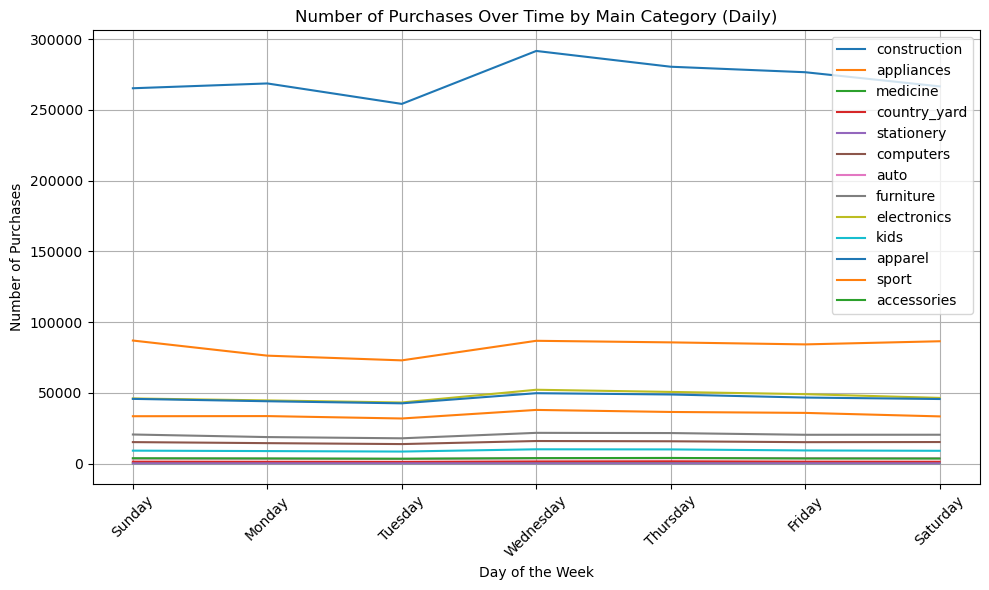

In [29]:
# Aggregate data by day of the week and main_category, and count purchases
daily_purchases = combined_df_clean \
    .filter(combined_df_clean['event_type'] == 'purchase') \
    .groupBy(dayofweek('event_time').alias('weekday'), 'main_category') \
    .count() \
    .orderBy('weekday')

# Collect data for plotting
plot_data = daily_purchases.collect()

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))

# Mapping weekdays to their names
weekday_names = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

for category in set([row['main_category'] for row in plot_data]):
    category_data = [row for row in plot_data if row['main_category'] == category]
    plt.plot([weekday_names[row['weekday']] for row in category_data], [row['count'] for row in category_data], label=category)

plt.xlabel('Day of the Week')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases Over Time by Main Category (Daily)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Was man aus den verkaufszahlen der einzelnen kategorien rauslesen kann von jedem tag ist das der wechsel von Dienstag auf Mittwoch generell auf jede kategorie ein positiven einfluss von verkaufszahlen hat. Die construction kategorie ist am heufigsten vorkommende dies liegt warscheinlich daran das covid masken darunter fallen können.

## 2. Nutzerkäufe pro Sitzung
- Wie viele Produkte kauft ein durchschnittlicher Nutzer pro Sitzung?
- Wie viele verschiedene Produktkategorien kauft ein Nutzer im Durchschnitt während einer Sitzung, und wie kann diese Erkenntnis unsere Marketingstrategie beeinflussen? 
- Wie viele Produkte legt ein Nutzer durchschnittlich in den Warenkorb, bevor er einen Kauf tätigt, und wie wirkt sich diese Information auf die Werbestrategie aus?
- Wie viele Produkte aus derselben Kategorie legt ein Nutzer in den Warenkorb, bevor er einen Kauf tätigt, und wie kann dieses Detail unsere Werbestrategie beeinflussen?

### Wie viele Produkte kauft ein durchschnittlicher Nutzer pro Sitzung?

In [30]:
# Assuming combined_df_clean is your PySpark DataFrame

# Filter rows where the 'event_type' is 'purchase'
purchase_events = combined_df_clean.filter(combined_df_clean['event_type'] == 'purchase')

# Group by 'user_session' and count the number of purchases per session
purchase_counts_per_session = purchase_events.groupBy('user_session').count()

# Calculate the average number of purchases per user_session
average_purchase_per_session = purchase_counts_per_session.agg({'count': 'avg'}).collect()[0][0]

# Print the average number of purchases per user_session
print("Average number of purchases per user_session:", average_purchase_per_session)

Average number of purchases per user_session: 1.3098156705499184


### Wie viele verschiedene Produktkategorien kauft ein Nutzer im Durchschnitt während einer Sitzung, und wie kann diese Erkenntnis unsere Marketingstrategie beeinflussen? 

In [31]:
# Assuming combined_df_clean is your PySpark DataFrame

# Filter rows where the 'event_type' is 'purchase'
purchase_events = combined_df_clean.filter(combined_df_clean['event_type'] == 'purchase')

# Group by 'user_session' and count the number of purchases per session
purchase_counts_per_session = purchase_events.groupBy('user_session').count()

# Calculate the average number of purchases per user_session
average_purchase_per_session = purchase_counts_per_session.agg(F.avg('count').alias('avg_purchases')).first()['avg_purchases']

# Print the average number of purchases per user_session
print("Average number of purchases per user_session:", average_purchase_per_session)

Average number of purchases per user_session: 1.3098156705499184


### Wie viele Produkte legt ein Nutzer durchschnittlich in den Warenkorb, bevor er einen Kauf tätigt, und wie wirkt sich diese Information auf die Werbestrategie aus?

In [32]:
# Filter rows for 'cart' and 'purchase' events
cart_events = combined_df_clean.filter(combined_df_clean['event_type'] == 'cart')
purchase_events = combined_df_clean.filter(combined_df_clean['event_type'] == 'purchase')

# Group by 'user_session' and count cart additions and purchases
cart_counts_per_session = cart_events.groupBy('user_session').count()
purchase_counts_per_session = purchase_events.groupBy('user_session').count()

# Calculate the average number of cart additions and purchases per session
avg_cart_per_session = cart_counts_per_session.agg(F.avg('count').alias('avg_cart_per_session')).collect()[0]['avg_cart_per_session']
avg_purchase_per_session = purchase_counts_per_session.agg(F.avg('count').alias('avg_purchase_per_session')).collect()[0]['avg_purchase_per_session']

# Calculate the ratio between average cart additions and purchases
ratio = avg_cart_per_session / avg_purchase_per_session

# Print the conclusion
print("One person per User Session would add {:.5f} products to the cart before purchasing them.".format(ratio))

One person per User Session would add 1.35620 products to the cart before purchasing them.


### Wie viele Produkte aus derselben Kategorie legt ein Nutzer in den Warenkorb, bevor er einen Kauf tätigt, und wie kann dieses Detail unsere Werbestrategie beeinflussen?

In [33]:
# Filter rows for 'cart' and 'purchase' events
cart_events = combined_df_clean.filter(combined_df_clean['event_type'] == 'cart')
purchase_events = combined_df_clean.filter(combined_df_clean['event_type'] == 'purchase')

# Group by 'user_session' and 'secondary_category' and count cart additions and purchases
cart_counts_per_session_category = cart_events.groupBy('user_session', 'secondary_category').count()
purchase_counts_per_session_category = purchase_events.groupBy('user_session', 'secondary_category').count()

# Calculate the average number of cart additions and purchases per session and category
avg_cart_per_session_category = cart_counts_per_session_category.agg(F.avg('count').alias('avg_cart_per_session_category')).collect()[0]['avg_cart_per_session_category']
avg_purchase_per_session_category = purchase_counts_per_session_category.agg(F.avg('count').alias('avg_purchase_per_session_category')).collect()[0]['avg_purchase_per_session_category']

# Calculate the ratio between average cart additions and purchases
ratio = avg_cart_per_session_category / avg_purchase_per_session_category

# Print the conclusion
print("One person per User Session with the same product category would add {:.5f} products to the cart before purchasing them."
      .format(ratio))

One person per User Session with the same product category would add 1.36161 products to the cart before purchasing them.


From the chunks above, we could conclude that:
1. One person would purchase an average of 1.310 products per User Session
2. One person would purchase an average of 1.040 different product category per User Session
3. One person would add an average of 1.356 product with the same product category per User Session
4. One person would add an average of 1.362 product with the same product category per User Session

The data can be used for businesses strategies, for example how many ads they would need to purchase in the ecommerce. 

## 3. Was ist die total Umsatz?
- abhängig von Brand 
- abhängig von Main Category

### abhängig von Brand 

In [34]:
# Extracting the month from the 'event_time' column and creating 'combined_df_clean_extracted'
combined_df_clean_extracted = combined_df_clean.withColumn('month', month('event_time'))

# Filtering out rows with NaN in the 'brand' column
grouped_data = combined_df_clean_extracted.filter(col('brand').isNotNull())

# Filtering rows where 'event_type' is 'purchase' and grouping by 'month', 'brand' to calculate 'revenue' and 'purchased_product'
grouped_data = grouped_data.filter(col('event_type') == 'purchase') \
    .groupBy('month', 'brand') \
    .agg(sum('price').alias('total_revenue'), count('event_type').alias('n_purchased_product'))

grouped_data = grouped_data.withColumn('month', 
    when(col('month') == 1, 'January')
    .when(col('month') == 2, 'February')
    .when(col('month') == 3, 'March')
    .when(col('month') == 4, 'April')
    .otherwise(col('month')))

# Sort the resulting DataFrame by 'total_revenue' in descending order
grouped_data = grouped_data.orderBy(col('total_revenue').desc())

# Show the resulting sorted DataFrame
grouped_data.show()

+--------+-------+--------------------+-------------------+
|   month|  brand|       total_revenue|n_purchased_product|
+--------+-------+--------------------+-------------------+
|February|  apple|1.9175556765001187E8|             268971|
|   March|  apple|1.4131533977999613E8|             190726|
| January|  apple|1.2584414384000158E8|             170486|
|   April|  apple| 7.428806738000011E7|              97694|
|February|samsung| 7.425748777000062E7|             272330|
|   March|samsung| 6.543173936000014E7|             229862|
|   April|samsung| 5.678420599000099E7|             220113|
| January|samsung|5.5775446020000465E7|             205304|
|February| xiaomi| 1.764899427000024E7|             107985|
|   March| xiaomi|1.2524974390000045E7|              69153|
|   April| xiaomi|1.2064864839999957E7|              63046|
| January| xiaomi| 1.196822013999994E7|              74724|
|February| huawei|   7667155.310000014|              41163|
|   April|     lg|   7539392.839999993| 

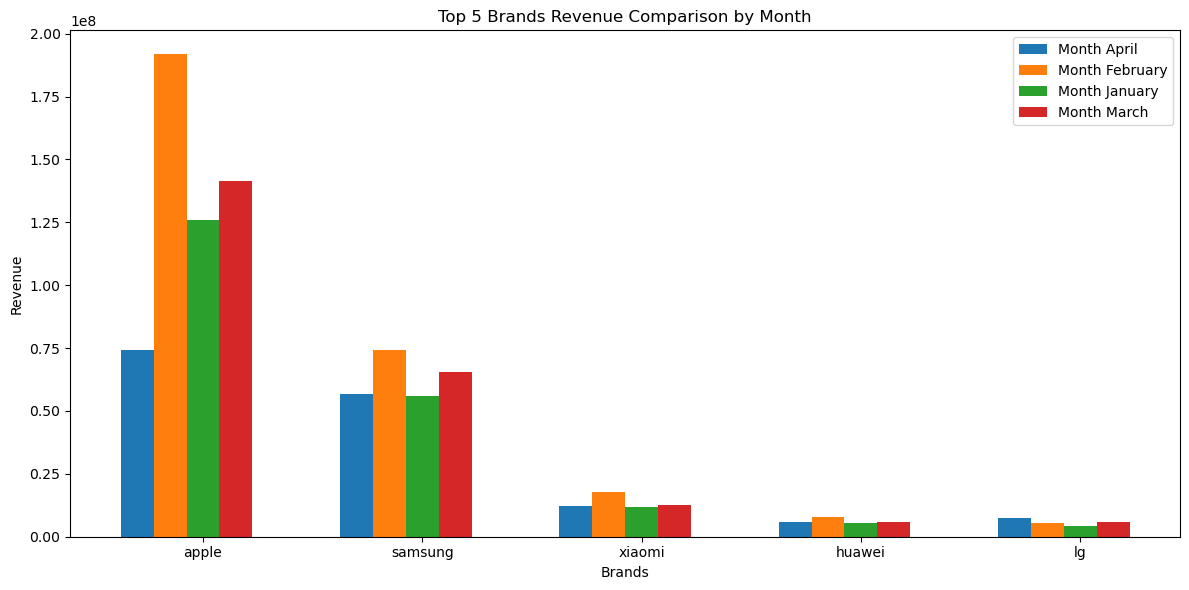

In [35]:
# Window specification to partition by month and rank brands based on total_revenue
window_spec = Window.partitionBy('month').orderBy(col('total_revenue').desc())
average_revenue = grouped_data.groupBy('brand').agg(avg('total_revenue').alias('average_revenue'))

# Add a rank to each brand within each month based on total revenue
result_df_with_rank = grouped_data.withColumn('rank', row_number().over(window_spec))

# Filter the top 5 brands with the highest revenue for each month
top_5_brands_per_month = result_df_with_rank.join(average_revenue, on='brand', how='left')

# Get main_categories sorted by average revenue in descending order
# Collecting data to be used for plotting
sorted_brand = average_revenue.orderBy(col('average_revenue').desc()).limit(5).select('brand').rdd.flatMap(lambda x: x).collect()
months = sorted(top_5_brands_per_month.select('month').distinct().rdd.flatMap(lambda x: x).collect())

# Prepare data for plotting
data = {
    month: top_5_brands_per_month.filter(col('month') == month).select('brand', 'total_revenue').rdd.collectAsMap()
    for month in months
}

# Plotting bar plots for top 5 brands' revenue comparison across months
plt.figure(figsize=(12, 6))
bar_width = 0.15
for i, month in enumerate(months):
    revenues = [data[month].get(brand, 0) for brand in sorted_brand]
    plt.bar([x + i * bar_width for x in range(len(sorted_brand))], revenues, width=bar_width, label=f"Month {month}")

plt.xlabel('Brands')
plt.ylabel('Revenue')
plt.title('Top 5 Brands Revenue Comparison by Month')
plt.xticks([x + bar_width * len(months) / 2 for x in range(len(sorted_brand))], sorted_brand)
plt.legend()
plt.tight_layout()
plt.show()



### abhängig von Main Category

In [36]:
# Filtering out rows with NaN in the 'main_category' column
grouped_data_category = combined_df_clean_extracted.filter(col('main_category').isNotNull())

# Filtering rows where 'event_type' is 'purchase' and grouping by 'month', 'brand' to calculate 'revenue' and 'purchased_product'
grouped_data_category = grouped_data_category.filter(col('event_type') == 'purchase') \
    .groupBy('month', 'main_category') \
    .agg(sum('price').alias('total_revenue'), count('event_type').alias('n_purchased_product'))

grouped_data_category = grouped_data_category.withColumn('month', 
    when(col('month') == 1, 'January')
    .when(col('month') == 2, 'February')
    .when(col('month') == 3, 'March')
    .when(col('month') == 4, 'April')
    .otherwise(col('month')))

# Sort the resulting DataFrame by 'total_revenue' in descending order
grouped_data_category = grouped_data_category.orderBy(col('total_revenue').desc())

# Show the resulting sorted DataFrame
grouped_data_category.show()

+--------+-------------+--------------------+-------------------+
|   month|main_category|       total_revenue|n_purchased_product|
+--------+-------------+--------------------+-------------------+
|February| construction|2.6972798557000065E8|             617290|
|   March| construction|2.0619133444999826E8|             470373|
| January| construction|1.7606172534999973E8|             420131|
|   April| construction| 1.366515239299982E8|             395513|
|   April|   appliances| 4.275452728999993E7|             178564|
|   March|   appliances| 3.971439610999987E7|             142468|
|February|   appliances| 3.729254854000001E7|             143396|
| January|   appliances|3.4519439849999756E7|             114786|
|   March|  electronics|3.0391852160000198E7|              89001|
|February|  electronics| 2.802213858999994E7|              94561|
|   April|  electronics|2.7770856059999947E7|              84494|
| January|  electronics|1.7871134359999955E7|              64015|
|February|

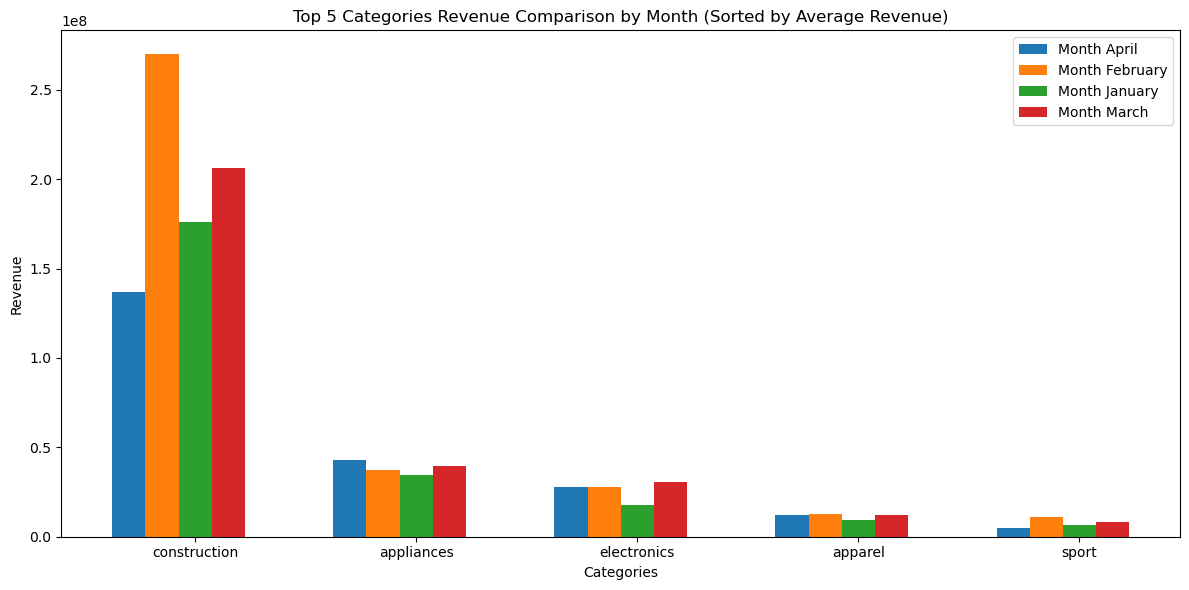

In [37]:
# Calculating the average revenue for each main category
average_revenue = grouped_data_category.groupBy('main_category').agg(avg('total_revenue').alias('average_revenue'))

# Adding a rank to each main category within each month based on total revenue
window_spec = Window.partitionBy('month').orderBy(col('total_revenue').desc())
result_df_with_rank = grouped_data_category.withColumn('rank', row_number().over(window_spec))

# Joining the ranked DataFrame with average revenue data
top_5_main_categories_per_month = result_df_with_rank.join(average_revenue, on='main_category', how='left')

# Getting the top 5 main categories sorted by average revenue in descending order
sorted_main_categories = average_revenue.orderBy(col('average_revenue').desc()).limit(5).select('main_category').rdd.flatMap(lambda x: x).collect()

# Collecting data for plotting
months = sorted(top_5_main_categories_per_month.select('month').distinct().rdd.flatMap(lambda x: x).collect())

# Prepare data for plotting for top 5 main categories
data = {
    month: top_5_main_categories_per_month.filter((col('month') == month) & (col('main_category').isin(sorted_main_categories)))
                                          .select('main_category', 'total_revenue').rdd.collectAsMap()
    for month in months
}

# Plotting bar plots for top 5 main_categories' revenue comparison across months
plt.figure(figsize=(12, 6))
bar_width = 0.15
for i, month in enumerate(months):
    revenues = [data[month].get(main_category, 0) for main_category in sorted_main_categories]
    plt.bar([x + i * bar_width for x in range(len(sorted_main_categories))], revenues, width=bar_width, label=f"Month {month}")

plt.xlabel('Categories')
plt.ylabel('Revenue')
plt.title('Top 5 Categories Revenue Comparison by Month (Sorted by Average Revenue)')
plt.xticks([x + bar_width * len(months) / 2 for x in range(len(sorted_main_categories))], sorted_main_categories)
plt.legend()
plt.tight_layout()
plt.show()


## 4. Welche Produktkategorien werden während Corona mehr oder weniger verkauft?
- Filtern Sie die Daten auf den Zeitraum während der Corona-Pandemie.
- Gruppieren Sie die Daten nach Produktkategorien und zählen Sie die Verkäufe.
- Vergleichen Sie die Verkaufszahlen vor und während der Corona-Pandemie.
- Analysieren Sie mögliche Preissteigerungen oder -senkungen in bestimmten Kategorien.


PLOTTING WITH DATETIME AS X-AXIS

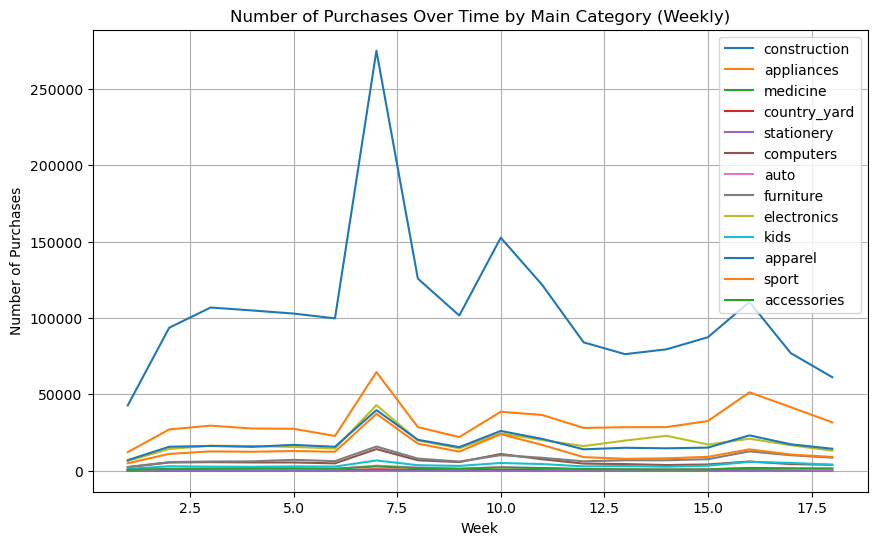

In [ ]:
import datetime


year = 2020


def first_day_of_week(week):
    return datetime.datetime.strptime(f'{year}-W{int(week )- 1}-1', "%Y-W%W-%w").date()


weekly_purchases = combined_df_clean \
    .filter(combined_df_clean['event_type'] == 'purchase') \
    .groupBy(weekofyear('event_time').alias('week'), 'main_category') \
    .count() \
    .orderBy('week')

plot_data = weekly_purchases.collect()
main_categories = set([row['main_category'] for row in plot_data])

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))

for category in main_categories:
    category_data = [row for row in plot_data if row['main_category'] == category]
    weeks = [first_day_of_week(row['week']) for row in category_data]
    purchases = [row['count'] for row in category_data]
    plt.plot(weeks, purchases, label=category)

plt.xlabel('Date (First Day of Week)')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases Over Time by Main Category (Weekly)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.show()


Was man aus den verkaufszahlen der einzelnen kategorien rauslesen kann über die corona zeitspanne ist das ein paar kategorien weniger umsatz gemacht haben als die
corona pandemie begonnen hat und ein paar mehr umsatz gemacht haben. Die construction kategorie aber eigentlich gewachsen dies liegt warscheinlich daran 
das covid masken darunter fallen können.

## 5. Welche Marken profitieren mehr oder weniger während der Corona-Pandemie?
- Analysieren Sie die Verkaufszahlen nach Marken.
- Vergleichen Sie die Verkaufszahlen vor und während der Corona-Pandemie für jede Marke.
- Ermitteln Sie, welche Marken einen Anstieg oder Rückgang der Verkäufe verzeichnen.


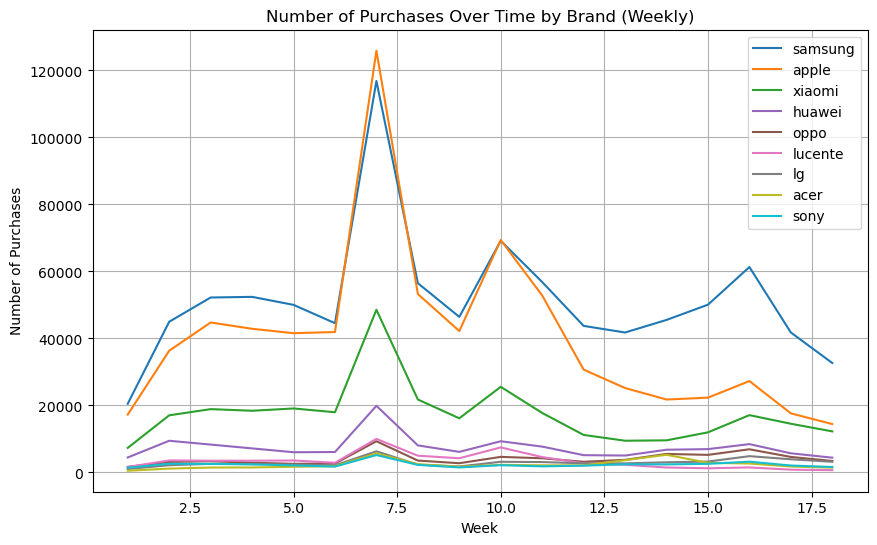

In [39]:
from pyspark.sql.functions import to_date

# First, identify the top brands
top_brands = combined_df_clean.filter(combined_df_clean['event_type'] == 'purchase') \
    .groupBy('brand').count().orderBy('count', ascending=False) \
    .limit(10).select('brand').rdd.flatMap(lambda x: x).collect()

# Convert 'event_time' to a date format and aggregate data for top brands
daily_brand_purchases = combined_df_clean \
    .filter((combined_df_clean['event_type'] == 'purchase') & (combined_df_clean['brand'].isin(top_brands))) \
    .withColumn('date', to_date('event_time')) \
    .groupBy('date', 'brand') \
    .count() \
    .orderBy('date')

# Collect data for plotting
plot_data = daily_brand_purchases.collect()

# Create a color map for brands
import matplotlib.pyplot as plt
colors = plt.cm.tab10.colors[:len(top_brands)]

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))

for i, brand in enumerate(top_brands):
    brand_data = [row for row in plot_data if row['brand'] == brand]
    plt.plot([row['date'] for row in brand_data], [row['count'] for row in brand_data], label=brand, color=colors[i])

plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases Over Time by Brand (Daily)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()


wie man an den verkaufsdaten von den einzelnen marken sieht sind die verkaufszahlen generell sehr ungleichmäsig geblieben. Samsung und apple haben
am meisten verkauft aber beide haben sehr viele und starke schwankungen gehabt in ihren verkaufszahlen. Samsung ist aber gegen ende defenitiv als verkaufs
sieger rausgekommen da es sehr viel verkauft hat als die pandemie noch in vollem schwung war vieleicht liegt dies daran das apple keine microchips mehr hatte oder andere gründe.

# SAVE THE DATA TO CSV TO BE LOADED IN THE BUCKET

In [40]:
minio_bucket_new = 'deltaecommerce'

# Convert combined_df_clean (assuming it's a DataFrame) to Delta format and save it to MinIO
# Create a Delta table from the DataFrame and overwrite if it exists
combined_df_clean.write.format("delta").mode("overwrite").save(f"s3a://{minio_bucket_new}/combined_df_clean_analyzed")


In [41]:
# # Assuming combined_df_clean is your PySpark DataFrame

# # Specify the output path where you want to save the CSV file
# output_path = "combined_df_clean_analyzed.csv"

# # Write the DataFrame to a CSV file
# combined_df_clean.write.csv(output_path, header=True, mode="overwrite")
